# Continuous Pendulum with function appoximation and control

This Notebook is intended to solve the Continuous Pendulum problem using Policy gradient methods (Deep actor-critic) with experience replay.

The description of the problem is given below:

"The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.." 

<img src="./assets/pendulum.png" width="380" />

Image and eext taken from [Official documentaiton Pendulum](https://gym.openai.com/envs/Pendulum-v0/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from copy import deepcopy
import gym
from gym.wrappers import Monitor
from utils import *

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Markov Decision Process

As a quick recap, the diagram below explains the workflow of a Markov Decision Process (MDP)

<img src="./assets/MDP.png" width="380" />

Image taken from [Section 3.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=70)

## Environment and Agent specifications

The states, actions, reward and termination are given as follows for the lunar lander problem.

**Observation**: 

     Type:  Box(2)
     Num 	Observation 	 Min 	Max
     0 	  cos(theta)      -1.0 	1.0
     1 	  sin(theta) 	 -1.0 	1.0
     2       theta dot 	  -8.0 	8.0
         
**Actions**:

     Type: Box(1)
     Num 	Action 	        Min 	Max
     0 	  Joint effort      -2.0 	2.0

        
**Reward**:

     -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2)

        
**Starting State**:

     Random angle from -pi to pi, and random velocity between -1 and 1
        
**Episode Termination**:

     Continuous problem
     
For further information see [Github source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

The next cell aims to show how to iterate with the action and observation space of the agent and extract relevant information from it 

In [2]:
env = gym.make("Pendulum-v0")
observation = env.reset() 

# Object's type in the action Space
print("The Action Space is an object of type: {0}\n".format(env.action_space))
# Shape of the action Space
print("The shape of the action space is: {0}\n".format(env.action_space.shape))
# The high and low values in the action space
print("The High values in the action space are {0}, the low values are {1}\n".format(
    env.action_space.high, env.action_space.low))
# Object's type in the Observation Space
print("The Environment Space is an object of type: {0}\n".format(env.observation_space))
# Shape of the observation space
print("The Shape of the dimension Space are: {0}\n".format(env.observation_space.shape))
# The high and low values in the observation space
print("The High values in the observation space are {0}, the low values are {1}\n".format(
    env.observation_space.high, env.observation_space.low))
# Example of observation
print("The Observations at a given timestep are {0}\n".format(env.observation_space.sample()))

The Action Space is an object of type: Box(1,)

The shape of the action space is: (1,)

The High values in the action space are [2.], the low values are [-2.]

The Environment Space is an object of type: Box(3,)

The Shape of the dimension Space are: (3,)

The High values in the observation space are [1. 1. 8.], the low values are [-1. -1. -8.]

The Observations at a given timestep are [ 0.57545656 -0.8486819   2.7881505 ]



## Critic Neural Network

For this problem, the critic is a Neural Network with a single output. The input dimension is equal to the number of states in the problem. Recall that.

$$ v_\pi(s) \approx \hat{v}(s, w) = NN(s, w) $$

<img src="./assets/nn_2.png" width="340" />

For further information about Neural Networks for function approximation see [Section 9.7 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=246). **Note**: Image taken from the last reference

In [3]:
# Critic Neural Network
class Critic(nn.Module):
    # Work Required: Yes. Fill in the layer_sizes member variable (~1 Line).
    def __init__(self, critic_config):
        super().__init__()
        
        # Number of states
        self.state_dim = critic_config.get("state_dim")
        # Hidden units
        self.num_hidden_units = critic_config.get("num_hidden_units")
        
        # Initialzie first hidden layer 
        self.hidden_1 = nn.Linear(self.state_dim, self.num_hidden_units)
        # Initialzie second hidden layer 
        self.hidden_2 = nn.Linear(self.num_hidden_units, self.num_hidden_units)
        # Initialize output layer
        self.output = nn.Linear(self.num_hidden_units, 1)
                                
    
    def forward(self, s):
        """
        This is a feed-forward pass in the network
        Args:
            s (Numpy array): The state, a 2D array of shape (state_dim)
        Returns:
            The value estimates (Torch array) calculated using the network's weights.
            A 2D array of shape (num_actions)
        """
        # Transform observations into a pytorch tensor
        s = torch.Tensor(s)
        
        v = F.relu(self.hidden_1(s))
        v = F.relu(self.hidden_2(v))
        v = self.output(v)

        return v

## Actor Neural Network

As this is a contininuous problem, it is possible to use a Normal distribution to sample actions. For this task, a neural network is used to compute $\mu$ which is the mean. The value of $\sigma$ or standard deviation is updated by the backprop algorithm, nevertheless, it is set to a fixed value from the beginning. The NN is not used to compute $\sigma$ as different tests showed that computing both values make the experiment quite unstable.

$$ \pi(a | s, \theta) \doteq \frac{1}{\sigma(s, \theta) \sqrt{2\pi}}e^-{\frac{(a-\mu(s,\theta))^2}{2\sigma(s,\theta)^2}} $$

As $\mu$ is computed by the network, $\mu$ and $\sigma$ are automatically adjusted depending on the current state of the problem. The input of the neural netork are the states of the problem, the output is composed of one output node ($\mu$) owing to the unique action in this problem.

For further explanation see [Section 13.7 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=357)

In [4]:
# The Actor neural network
class Actor(nn.Module):
    def __init__(self,  actor_config):
        super().__init__()
                
        # Number of states
        self.state_dim = actor_config.get("state_dim")
        # Hidden units
        self.num_hidden_units = actor_config.get("num_hidden_units")
        # Actions or output units
        self.num_actions = actor_config.get("num_actions")
        
        # Initialzie first hidden layer 
        self.hidden_1 = nn.Linear(self.state_dim, self.num_hidden_units)
        # Initialzie second hidden layer 
        self.hidden_2 = nn.Linear(self.num_hidden_units, self.num_hidden_units)
        # Initialize output layer (muliply output by 2 to obtain mu and sigma)
        self.output = nn.Linear(self.num_hidden_units, self.num_actions)
        
        # Log of standard deviation
        logstdv_param = nn.Parameter(torch.full((self.num_actions,), 0.1))
        # Register parameter in the network
        self.register_parameter("logstdv", logstdv_param)
                        
    def compute_mean(self, s):
        """
        This is a feed-forward pass in the network
        Args:
            s (Numpy array): The state, a 2D array of shape (state_dim)
        Returns:
            Mean and stdv (Torch array) calculated using the network's weights.
            A 2D array of shape (num_actions * 2)
        """
        # Transform observations into a pytorch tensor
        s = torch.Tensor(s)
        
        pi = F.relu(self.hidden_1(s))
        pi = F.relu(self.hidden_2(pi))
        pi = self.output(pi)
        
        return pi
                
    
    def forward(self, s):
        
        # Compute the mean and log stedv with the model
        mean = self.compute_mean(s)
        
        # Exp the logstdv to avoid negative values and clamp the stdv between 1e-3 and 50
        stdv = torch.clamp(self.logstdv.exp(), 1e-3, 50)
        
        # Sample an action from the normal distribution
        return torch.distributions.Normal(mean, stdv)


## Replay Buffer

Experience replay is a technique very similar to planning in RL. Overall, this technique is used to update the action-values of the agent with a set of "experience" collected in a model. This experience allows the model to learn without interacting with the environment using simulated experience.

Experience replay is a simple method that can get some of the advantages of planning by saving a buffer of experience and using the data stored in the buffer as a model. This view of prior data as a model works because the data represents actual transitions from the underlying MDP. The data stored in the model are the state, action, reward and next state. 

The model will be filled until a queue size is reached, only then the model will drop its oldest observation and add a new one. With this buffer of information, it is possible to sample "batches" and update the action values of the agent.

As a quick recap, the next pseudocode shows the pseudocode for Dyna-Q algorithm where the agent performs planning steps, improving the learning process of the agent with simulated experience.

<img src="./assets/dyna-q.png" width="480" />

The planning process is given in the next image.

<img src="./assets/planning.png" width="320" />

For further information about planning see [Section 8.2 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=185). **Note**: Images taken from the last reference.


In [5]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
        """
        # Create the buffer
        self.buffer = [] 
        self.minibatch_size = minibatch_size
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state of size (state_dim)            
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state of size (state_dim) .           
        """
        if len(self.buffer) == self.max_size:
            # Delete first position of the buffer if the Queue size is equals to max size
            del self.buffer[0]
        # Append new step
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
            The return of this function is of size (minibatch_size)
        """
        idxs = np.random.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Computing TD target and TD estimate

The TD target and TD estimate's computation will be done in the next lines. The main idea here is to obtain both TD values from the Critic's network.

At time $t$, there is a value estimate function represented as a neural network, say $V_t$. The idea is to update the value estimates function and get a new one we can use at the next timestep. We will get this $V_{t+1}$ using multiple replay steps that each result in an intermediate Value estimate function $V_{t+1}^{i}$ where $i$ indexes which replay step we are at.

In each replay step, we sample a batch of experiences from the replay buffer and compute a minibatch TD(0) update (Critic) + Actor critic update. Across these N replay steps, we will use the current "un-updated" value estimate network at time $t$, $V_t$, for computing the value estimate of the next-states. This contrasts using the most recent action-values from the last replay step $V_{t+1}^{i}$. We make this choice to have targets that are stable across replay steps. Here is the pseudocode for performing the updates:

$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } V_{t+1}^1 \leftarrow V_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do TD(0) update with } V_t: V_{t+1}^{i+1}(s, w) \leftarrow V_{t}^{i}(s, w) + \alpha \cdot \left[r + \gamma \left(V_t(s', w)\right) - V_{t+1}^{i}(s, w)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(V_t(s', w)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } V_{t+1}^{N} \text{ as } V_{t+1} \text{ and have a new } V_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$


The TD error is composed of two values, the TD estimate and TD Target.

$$ \delta = [R_{t+1} + \gamma \hat{v}(S_{t+1}, w) - \hat{v}(s_t,w)] = \text{TD error} $$
 
Recall that the TD Target is given by.

$$ R_{t+1} + \gamma \hat{v}(S_{t+1}, w) $$

Similarly, the TD estimate is.

$$ \hat{v}(s_t,w) $$


For further explanation about TD methods see [Section 6.1 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=141)


In [6]:
# Method to compute the TD Target and TD estimate
def get_td(states, next_states, rewards, terminals, critic, current_critic, discount):
    """
    Args:
        states (Numpy array): States with shape (state_dim).
        next_states (Numpy array): Next states with shape (state_dim).
        rewards (float): Current reward.
        terminals (float): Terminal state.
        critic (Critic): The critic neural network used to compute value estimates
        discount (float): The discount factor (gamma).
    Returns:
        target_vec (Tensor value): The TD Target.
        estimate_vec (Tensor value): The TD estimate.
    """
    # Compute value estimates for the next states with the fixed network
    v_next_vals = current_critic.forward(next_states)
    # Compute value estimates for the current states (TD estimate) with the trainable network
    v_curr_vals = critic.forward(states).squeeze()
    
    # Compute the TD Target
    target_vec = torch.tensor(rewards) + (discount * v_next_vals.squeeze() * (1 - torch.tensor(terminals)))
    
    return target_vec, v_curr_vals

## Computing Network's optmizer

One important step is to optimize the network using the TD estimate and the TD target computed previously. As a quick recap, the Mean squared value error is used as loss function for the Critic.

$$\overline{VE} = \sum_s\mu(s)[V_\pi(s) - \hat{v}(s,w)]^2$$

Similarly, the loss function for the Actor newtork is given as follows:

$$ ActorLoss = \nabla \ln \pi(a_t | s_t, \theta_t) q_\pi(s_t,a_t) $$

The idea is to use $\overline{VE}$ as the Loss function to optimize the value estimates network. The actor's weights will be updated using gradient ascent with a different cost function. For this particular problem, the MSE implementation provided by Pytorch is used. Additionally, the Adam optimizer is used to optimize both actor and critis's weights.

See [Section 9.2 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=221) and [Section 13.3 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=348).

In [7]:
def optimize_network(experiences, discount, optimizer_c, optimizer_a, actor, critic, current_critic, criterion):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Return:
        Loss (float): The loss value for the current batch.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states) # Batch per states
    next_states = np.concatenate(next_states) # Batch per states
    rewards = np.array(rewards) # Batch size
    terminals = np.array(terminals) # Batch size
    batch_size = states.shape[0] # Batch size
    
    # Computing TD target and estimate using get_td function
    td_target, td_estimate = get_td(states, next_states, rewards, terminals, critic, current_critic, discount)
    
    # TD error calculation
    delta = td_target - td_estimate

    # Critic
    # zero the gradients buffer
    optimizer_c.zero_grad()
    # Compute the  Mean squared value error loss
    critic_loss = criterion(td_estimate.double().to(device), td_target.double().to(device))
    # Backprop the error
    critic_loss.backward()
    # Clip the gradients to 0.5
    clip_grad_norm_(optimizer_c, 0.5)
    # Optimize critic's network
    optimizer_c.step()

    # Actor 
    optimizer_a.zero_grad()
    # Compute mu and sigma
    norm_dists = actor.forward(states)
    # Construct equivalent loss function
    logs_probs = norm_dists.log_prob(torch.tensor(actions))
    # Multiply by minus one as this is gradient ascent
    actor_loss = (-logs_probs * delta.detach()).mean()
    # Backprop the error
    actor_loss.backward()
    # Clip the actor's gradients
    clip_grad_norm_(optimizer_a, 0.5)
    # Optimize the actor's network
    optimizer_a.step()
    
    return actor_loss.detach().numpy(), critic_loss.detach().numpy()

## Clipping the gradients

To guarantee stability in the training process, it is necessary to clip the gradients of the networks.

In [8]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

## Implementing Actor-Critic Agent

The final step is to implement the Agent. The training process is cyclical as this is a continuous task and the sequence goes as follows.

$\delta_t = R_{t+1}  + \gamma \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em}  (1)$

**Critic weight update rule**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em} (2)$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em} (3)$

The Actor-critic algorithm is presented in the next image. The actor produces a policy (action) that is 
immediately evaluated by the critic.

<img src="./assets/actor_critic.png" width="240" />

For further details, see [Section 13.5 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=353). **Note**: Image taken from [Reinforcement learning specialization, C3L4S4](https://www.coursera.org/learn/prediction-control-function-approximation/lecture/h9nDv/actor-critic-algorithm)

In [9]:
# Actor-Critic Agent
class ActorCritic():
    """
    Initialization of Actor-Critic Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        """Setup for the agent called when the experiment first starts."""
        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.avg_reward = None
        self.critic = None
        self.actor = None

        self.actions = None

        self.last_action = None
        self.last_state = None

    def agent_init(self, agent_config = {}):
        """Setup for the agent called when the experiment first starts."""
        
        # Step size parameters
        self.actor_step_size = agent_config['optimizers_config']['actor_step_size']
        self.critic_step_size = agent_config['optimizers_config']['critic_step_size']
        self.discount = agent_config['optimizers_config']['gamma']
        
        # Set number of actions
        self.actions = agent_config['network_config']['num_actions']
        
        # Initialize actor and critic networks
        self.actor = Actor(agent_config['network_config']).to(device)
        self.critic = Critic(agent_config['network_config']).to(device)
        
        # Critic Loss
        self.critic_loss = nn.MSELoss()
        
        # Create replay buffer
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'])
        # Number of times a minibatches that will be passed
        self.num_replay = agent_config['num_replay_updates_per_step']
        
        # Loss variables
        self.actor_loss_val = 0
        self.critic_loss_val = 0
        
        # Actor and Critic optimizer
        self.actor_opti = optim.Adam(self.actor.parameters(), lr = self.actor_step_size ) 
        self.critic_opti = optim.Adam(self.critic.parameters(), lr = self.critic_step_size )
        
        self.last_action = None
        self.last_state = None

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
            state (Numpy array): the state.
        Returns:
            chosen_action (float)
        """
        # Pass the states to create the normal distribution
        dist = self.actor.forward(state)
        # Sample an action from the current normal Distribution
        action = dist.sample().detach().data.numpy()
        # Clip action to a given range (Max and Min in action space)
        chosen_action = np.clip(action, env.action_space.low.min(), env.action_space.high.max())

        return chosen_action
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's env.reset() function.
        Returns:
            The first action the agent takes.
        """
        # Select an action given the current state
        current_action = self.select_action(state)
        # Save action as last action
        self.last_action = current_action
        # Save tiles as previous tiles
        self.last_state = np.array([state])
        
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # Select action
        action = self.select_action(state)
        # New state
        state = np.array([state])

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # Make a copy of the current network to obtain stable targets
            current_c = deepcopy(self.critic)
            for _ in range(self.num_replay):                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                # Call optimize_network to update the weights of the network (~1 Line)
                self.actor_loss_val, self.critic_loss_val = optimize_network(experiences, self.discount, 
                                                                             self.critic_opti, self.actor_opti, 
                                                                             self.actor, self.critic, current_c,
                                                                             self.critic_loss)
        # Store state, action
        self.last_state = state
        self.last_action = action

        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # There is no action_value used here because this is the end
        # of the episode.
        
        # Create state full of zeroes
        state = np.zeros_like(self.last_state)
        

        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # Make a copy of the current network to obtain stable targets
            current_c = deepcopy(self.critic)
            for _ in range(self.num_replay):                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                # Call optimize_network to update the weights of the network (~1 Line)
                self.actor_loss_val, self.critic_loss_val = optimize_network(experiences, self.discount, 
                                                                             self.critic_opti, self.actor_opti, 
                                                                             self.actor, self.critic, current_c,
                                                                             self.critic_loss)


## Running the experiment

The following lines solves the Pendulum problem and plot the average reward obtained over episodes and steps taken to solve the challenge at a specific episode (The experiment is over every x amount of steps).

In [10]:
# Test the Actor-Critic agent

num_runs = 1
num_episodes = 150

agent_info = {
             'network_config': {
                 'state_dim': env.observation_space.shape[0],
                 'num_hidden_units': 64,
                 'num_actions': env.action_space.shape[0]
             },
             'optimizers_config': {
                 'actor_step_size': 4e-4,  #5e-6, 1e-5 
                 'critic_step_size': 4e-3, # 4e-4, 4e-3
                 'gamma': 0.9, 
             },
                'replay_buffer_size': 50000,
                'minibatch_sz': 16,
                'num_replay_updates_per_step': 4}
            
# Variable to save the rewards in an episode
all_rewards = []
# Save actor and critic losses
all_loss_c = []
all_loss_a = []

# Agent
agent = ActorCritic()

# Environment
env = gym.make('Pendulum-v0')
env.reset()
# Maximum number of possible iterations (default was 200)
env._max_episode_steps = 200

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in range(num_runs):
    
    # Resets environment
    observation = env.reset()
    # Reset agent
    agent.agent_init(agent_info)
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
    # Steps, rewards and loss at each episode to solve the challenge
    rewards_per_episode = []
    loss_per_episode_c = []
    loss_per_episode_a = []
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):
        
        # Reset done flag
        done = False
        # Set rewards, steps and loss to zero
        rewards = 0
        agent.actor_loss_val = 0
        agent.critic_loss_val = 0
        # Reset environment
        observation = env.reset()
        # Run until the experiment is over
        while not done:
            
            # Render the environment 
            env.render()

            # Take a step with the environment
            observation, reward, done, info = env.step(last_action)
            
            rewards += reward.squeeze()

            # If the goal has been reached stop
            if done:
                # Last step with the agent
                agent.agent_end(reward)
            else:
                # Take a step with the agent
                last_action = agent.agent_step(reward, observation)
                
        # Reward obtained during the episode
        rewards_per_episode.append(rewards)
        # Losses obtained solving the experiment
        loss_per_episode_c.append(agent.critic_loss_val)
        loss_per_episode_a.append(agent.actor_loss_val)


    # Awards obtained during all episode
    all_rewards.append(np.array(rewards_per_episode))
    # Losses obtained during all episodes
    all_loss_c.append(np.array(loss_per_episode_c))
    all_loss_a.append(np.array(loss_per_episode_a))

env.close()

100%|██████████| 150/150 [10:17<00:00,  4.12s/it]


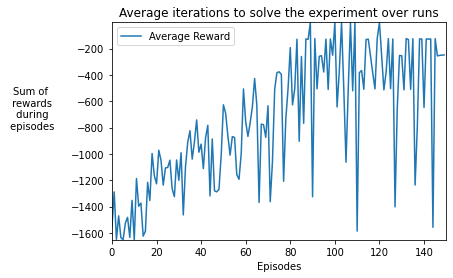

The best reward obtained solving the experiment was: -1.225467514357815

The WorSt reward obtained solving the experiment was: -1652.5802197851567



In [11]:
rewards_average = np.mean(all_rewards, axis=0)
plt.plot(rewards_average, label = 'Average Reward')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episodes" ,rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(rewards_average.min(), rewards_average.max())
plt.title("Average iterations to solve the experiment over runs")
plt.legend()
plt.show()
print("The best reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).max()))
print("The WorSt reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).min()))

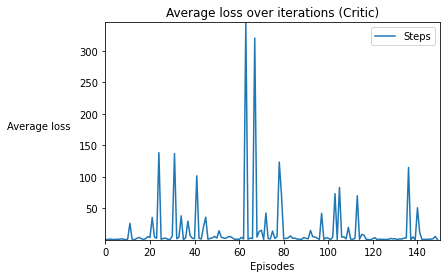

The best loss obtained with the Critic solving the experiment was: 0.2563592920590998

The Worst loss obtained with the Critic solving the experiment was: 345.100829997527



In [12]:
loss_average = np.mean(np.array(all_loss_c), axis=0)
plt.plot(loss_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Average loss",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(loss_average.min(), loss_average.max())
plt.title("Average loss over iterations (Critic)")
plt.legend()
plt.show()
print("The best loss obtained with the Critic solving the experiment was: {0}\n".format(np.array(loss_average).min()))
print("The Worst loss obtained with the Critic solving the experiment was: {0}\n".format(np.array(loss_average).max()))

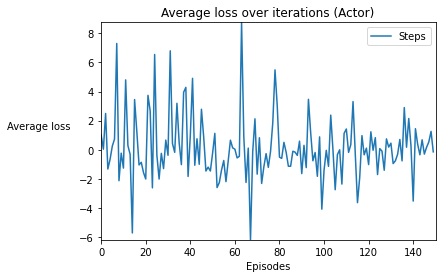

The best loss obtained with the Actor solving the experiment was: 8.754470956925347

The Worst loss obtained with the Actor solving the experiment was: -6.190843980750689



In [13]:
loss_average = np.mean(np.array(all_loss_a), axis=0)
plt.plot(loss_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Average loss",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(loss_average.min(), loss_average.max())
plt.title("Average loss over iterations (Actor)")
plt.legend()
plt.show()
print("The best loss obtained with the Actor solving the experiment was: {0}\n".format(np.array(loss_average).max()))
print("The Worst loss obtained with the Actor solving the experiment was: {0}\n".format(np.array(loss_average).min()))


## Using the last trained Agent 

This lines shows in a video the performance of the last trained agent and save a video with the results.

In [14]:
# Test Sarsa Agent 
num_runs = 1
num_episodes = 300

# Environment
env_to_wrap = gym.make('Pendulum-v0')
# Maximum number of possible iterations (default was 200)
env_to_wrap._max_episode_steps = 300
env = Monitor(env_to_wrap, "./videos/pendulum", video_callable=lambda episode_id: True, force=True)
total_reward = 0

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation = env.reset()
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):

        # View environment
        env.render()

        # Take a step with the environment
        observation, reward, done, info = env.step(last_action)
        total_reward += reward
        

        # If the goal has been reached stop
        if done:
            # Last step with the agent
            agent.agent_end(reward)
            break

        else:
            # Take a step with the agent
            last_action = agent.agent_step(reward, observation)


env.close()
env_to_wrap.close()

print("Episode finished with a total reward of".format(total_reward))

100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


Episode finished with a total reward of
